In [2]:
#@title ##Import stuff

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets.utils import download_url
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import tarfile
import os
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [3]:
#@title ##Some helper functions

def show_batch(dl):
  """
  takes the dataloader and plots a random batch
  of images as a grid.
  """
  for images, labels in dl:
      fig, ax = plt.subplots(figsize=(12, 6))
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
      print(labels)
      break

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
# def accuracy(model, data_loader):
#   """
#   Given a trained model and dataloader
#   computes the accuracy
#   """
#   model.eval()
#   correct_pred, num_examples = 0, 0
#   for i, (features, targets) in enumerate(data_loader):
          
#       features = features.to(DEVICE)
#       targets = targets.to(DEVICE)

#       logits, probas = model(features)
#       _, predicted_labels = torch.max(probas, 1)
#       num_examples += targets.size(0)
#       correct_pred += (predicted_labels == targets).sum()
#   return correct_pred.float()/num_examples * 100

# GPU related functions
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [4]:
#@title ##Tensorboard helper functions


# default `log_dir` is "runs" - we'll be more spefic here
writer = SummaryWriter('runs/VGG19_experiment_1')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(20, 48))
    for idx in np.arange(15):
      ax = fig.add_subplot(2, 15, idx+1, xticks=[], yticks=[])
      matplotlib_imshow(images[idx], one_channel=False)
      ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
          classes[preds[idx]],
          probs[idx] * 100.0,
          classes[labels[idx]]),
                  color=("green" if preds[idx]==labels[idx].item() else "red"))
    
    return fig


* ## Downloading & batching data

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
tensor([2, 9, 5, 2, 6, 1, 2, 6, 9, 7, 4, 8, 7, 7, 3, 8, 3, 7, 3, 9, 4, 2, 5, 0,
        5, 1, 2, 6, 3, 6, 0, 0, 7, 9, 5, 2, 1, 7, 1, 3, 1, 0, 8, 1, 1, 2, 1, 4,
        5, 1, 6, 7, 8, 1, 8, 2, 3, 4, 8, 8, 4, 5, 2, 6, 4, 7, 5, 8, 0, 9, 4, 1,
        6, 3, 9, 0, 7, 4, 6, 3, 7, 0, 0, 7, 9, 4, 1, 5, 2, 9, 7, 1, 7, 4, 2, 2,
        4, 1, 8, 9, 9, 3, 0, 1, 6, 3, 2, 2, 7, 3, 7, 0, 8, 5, 5, 1, 5, 6, 0, 4,
        3, 2, 8, 3, 5, 5, 1, 5, 2, 3, 9, 9, 2, 4, 6, 4, 7, 4, 4, 8, 2, 8, 1, 0,
        8, 8, 4, 7, 3, 9, 3, 9, 8, 5, 2, 3, 5, 6, 1, 7, 8, 4, 1, 1, 4, 9, 1, 4,
        6, 5, 9, 9, 0, 6, 1, 1, 9, 2, 2, 2, 2, 7, 9, 4, 6, 3, 4, 3, 5, 7, 0, 8,
        7, 7, 3, 8, 7, 1, 6, 0, 9, 1, 5, 2, 2, 0, 3, 4, 8, 7, 0, 3, 3, 3, 5, 6,
        7, 1, 0, 6, 4, 0, 3, 2, 0, 8, 2, 3, 9, 6, 0, 3, 9, 0, 3, 9, 2, 5, 0, 5,
        7, 3, 0, 8, 4, 7, 6, 4, 0, 7, 2, 3, 7, 5, 3, 6])


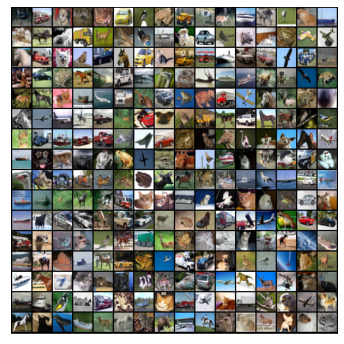

In [5]:
# Downloading trainset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
# Downloading testset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
# class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# splitting traing data into train & validation set
train_ds, val_ds = random_split(trainset, [45000, 5000])



##########################
### GLOBAL VARS.
##########################
# All the GLOBAL VARIABLES needed are declared here
batch = 256
img, _ = train_ds[0]
input_channels = img.shape[0]
num_classes = len(classes)


# turning all the datasets into batches of data
train_dl = DataLoader(trainset, batch, shuffle=True)
val_dl = DataLoader(val_ds, batch)
test_dl = torch.utils.data.DataLoader(testset, batch_size=batch,
                                         shuffle=False, num_workers=2)

# let's see how 1 batch of data data looks like
show_batch(train_dl)

In [6]:
#@title ##Loading everything into GPU

# setting device as GPU if available
device = get_default_device()

# Loading the batches of data into GPU
# train_dl = DeviceDataLoader(train_dl, device)
# val_dl = DeviceDataLoader(val_dl, device)

In [7]:
%load_ext tensorboard
!pip install tensorboard

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [8]:
import os
logs_base_dir = "runs"
os.makedirs(logs_base_dir, exist_ok=True)

In [9]:
#################
# plotting a batch of image from dataset to tensorboard
#################

# get some random training images
dataiter = iter(train_dl)
images, labels = dataiter.__next__()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# writer.add_image('CIFAR10_img_batch', img_grid)
#######END########

#################
# Projecting our high dimesional data into 3-dimension for viz purpose in tensorboard
#################
# select random images and their target indices
dataiter = iter(train_dl)
images, labels = dataiter.__next__()

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]
print(labels.shape, images.shape)
# log embeddings
features = images.view(batch, -1)
print(features.shape, images.unsqueeze(1).shape)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images)
#######END########


# writer.close()

torch.Size([256]) torch.Size([256, 3, 32, 32])
torch.Size([256, 3072]) torch.Size([256, 1, 3, 32, 32])


* ## Let's now make the model...

* #### The architecture for our model
<img src = "https://raw.githubusercontent.com/khalidsaifullaah/Classic-Deep-Learning-Models/master/VGGNet/vgg-19-architecture.png" width ="20%" height = "20%" align="center"/>

In [10]:
# This one is the parent class of our model,
# It holds many basic methods like cost calc, printing result of a model etc.
class Training_Modules(nn.Module):
  def cost(self, batch):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)
    preds = self(imgs)
    loss = F.cross_entropy(preds, labels)
    return loss

  def val_step(self, batch):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)
    preds = self(imgs)
    loss = F.cross_entropy(preds, labels)
    acc = accuracy(preds, labels)    
    return {'val_loss': loss, 'val_acc': acc}

  def validation_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]   
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def print_result(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [25]:
class Conv_Block(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    super(ConvBlock, self).__init__()
    self.cnn_layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels), 
        nn.ReLU()
    )

  def forward(self, x):
    return self.cnn_layer(x)

torch.Size([1, 64, 32, 32])

In [27]:
class Inception_Block(nn.Module):
  def __init__(self, in_channels, num_1x1, num_3x3, num_5x5, bottleneck_3x3, bottleneck_5x5, bottleneck_pooling):
    super(Inception_Block, self).__init__()
    self.cluster_1 = nn.Sequential(
        Conv_Block(in_channels, num_1x1, kernel_size = 1)
    )
    self.cluster_2 = nn.Sequential(
        Conv_Block(in_channels, bottleneck_3x3, kernel_size = 1),
        Conv_Block(bottleneck_3x3, num_3x3, kernel_size = 3, padding = 1)
    ) 
    self.cluster_3 = nn.Sequential(
        Conv_Block(in_channels, bottleneck_5x5, kernel_size = 1),
        Conv_Block(bottleneck_3x3, num_3x3, kernel_size = 5, padding = 1)
    ) 
    self.cluster_4 = nn.Sequential(
        nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
        Conv_Block(in_channels, bottleneck_pooling, kernel_size = 1)
    ) 
    

  def forward(self, x):
    cluster_1 = self.cluster_1(x)
    cluster_2 = self.cluster_2(x)
    cluster_3 = self.cluster_3(x)
    cluster_4 = self.cluster_4(x)
    
    return torch.cat([cluster_1, cluster_2, cluster_3, cluster_4], 1)



SyntaxError: ignored